In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import multiprocessing
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [19]:
data = pd.read_csv('../../reference/f1_cleaned.csv')
data = data.rename(columns={'driver_name' : 'team_name'})
data.drop(['code'], axis=1, inplace=True)
data.dtypes

team_name         object
driver_nat        object
circuitRef        object
year             float64
round            float64
starting_pos     float64
finishing_pos    float64
laps             float64
quali_mean       float64
driver_age       float64
driver_dnf         int64
car_dnf            int64
dtype: object

In [20]:
#train test split
#we are not using a random split here, training with pre 2024 data and trying to predict the races that occured in 2024

train = data[data.year<2024].copy()
test = data[data.year==2024].copy()

#testing set
y_test = test.pop('finishing_pos')
x_test = test

#training set
y_train = train.pop('finishing_pos')
x_train = train

In [21]:
print("Selected columns:", x_train.columns.tolist())
print("Selected columns:", x_test.columns.tolist())

Selected columns: ['team_name', 'driver_nat', 'circuitRef', 'year', 'round', 'starting_pos', 'laps', 'quali_mean', 'driver_age', 'driver_dnf', 'car_dnf']
Selected columns: ['team_name', 'driver_nat', 'circuitRef', 'year', 'round', 'starting_pos', 'laps', 'quali_mean', 'driver_age', 'driver_dnf', 'car_dnf']


In [22]:
#encoding vars and scaling data

cat_feat = ['team_name',
            'driver_nat', 
            'circuitRef']
x_num_feat = ['year',
              'starting_pos', 
              'laps', 
              'driver_dnf', 
              'car_dnf',
              'round',
              'quali_mean',
              'driver_age']

#scale y later if needed for a distance model

# ct = ColumnTransformer(transformers=[
#     ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_feat), #avoid dummy var trap with OHE
#     ('scx', StandardScaler(), x_num_feat)
# ])

# --- Encoding with threshold function ---
def encode_with_threshold(df, cols, threshold=0.02):
    new_df = df.copy()
    for col in cols:
        freq = new_df[col].value_counts(normalize=True)
        keep = freq[freq > threshold].index
        new_df[col] = np.where(new_df[col].isin(keep), new_df[col], 'Other')
    return pd.get_dummies(new_df, columns=cols, drop_first=True)

# --- Apply encoding ---
x_train_encoded = encode_with_threshold(x_train, cat_feat)
x_test_encoded = encode_with_threshold(x_test, cat_feat)

# --- Scale numeric features ---
scaler = StandardScaler()
x_train_encoded[x_num_feat] = scaler.fit_transform(x_train_encoded[x_num_feat])
x_test_encoded[x_num_feat] = scaler.transform(x_test_encoded[x_num_feat])

# --- Align columns between train and test ---
x_train_encoded, x_test_encoded = x_train_encoded.align(x_test_encoded, join='left', axis=1, fill_value=0)

# --- Add constant (intercept) ---
x_train_encoded = sm.add_constant(x_train_encoded)
x_test_encoded = sm.add_constant(x_test_encoded)

# --- Force float type to avoid errors ---
x_train_encoded = x_train_encoded.astype(float)
y_train = y_train.astype(float)

# Backward Elimination

In [23]:
# --- Define backward elimination function ---
def backward_elimination(x, y, sl=0.05):
    numVars = len(x.columns)
    for i in range(numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            excluded_feature = regressor_OLS.pvalues.idxmax()
            print(f"Dropping '{excluded_feature}' with p-value {maxVar:.4f}")
            x = x.drop(columns=[excluded_feature])
        else:
            break
    regressor_OLS.summary()
    return x, regressor_OLS

# --- Run backward elimination ---
x_train_be, model_be = backward_elimination(x_train_encoded, y_train)

# --- Prepare selected features for final model ---
selected_features = x_train_be.drop(columns='const').columns.tolist()
x_test_be = x_test_encoded[selected_features]

Dropping 'circuitRef_yas_marina' with p-value 0.9561
Dropping 'driver_nat_German' with p-value 0.8520
Dropping 'circuitRef_bahrain' with p-value 0.7135
Dropping 'driver_age' with p-value 0.6892
Dropping 'circuitRef_suzuka' with p-value 0.6534
Dropping 'circuitRef_sepang' with p-value 0.6196
Dropping 'circuitRef_sochi' with p-value 0.6574
Dropping 'driver_nat_Swedish' with p-value 0.5812
Dropping 'driver_nat_British' with p-value 0.6319
Dropping 'circuitRef_marina_bay' with p-value 0.5528
Dropping 'circuitRef_hockenheimring' with p-value 0.5363
Dropping 'driver_nat_Danish' with p-value 0.3732
Dropping 'driver_nat_Mexican' with p-value 0.3724
Dropping 'circuitRef_interlagos' with p-value 0.3323
Dropping 'circuitRef_baku' with p-value 0.2641
Dropping 'circuitRef_monza' with p-value 0.2279
Dropping 'circuitRef_villeneuve' with p-value 0.1760
Dropping 'circuitRef_red_bull_ring' with p-value 0.1717
Dropping 'circuitRef_americas' with p-value 0.1406
Dropping 'circuitRef_spa' with p-value 0.14

## Linear Regression Model

In [31]:
# --- Train final Linear Regression model ---
lr = LinearRegression()
lr.fit(x_train_be.drop(columns='const'), y_train)

# --- Predict on test set ---
y_pred = lr.predict(x_test_be)

# --- Evaluate the model ---
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# --- Calculate Adjusted R2 ---
n = x_test_be.shape[0]  # number of samples
p = x_test_be.shape[1]  # number of predictors

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# --- Print results ---
print('Final Model Results:')
print(f'R2: {r2:.4f}')
print(f'Adjusted R2: {adjusted_r2:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

Final Model Results:
R2: 0.6383
Adjusted R2: 0.6167
Root Mean Squared Error (RMSE): 3.4616
Mean Absolute Error (MAE): 2.7618


## Visualization

In [25]:
#df created to compare results 

comparison_df = pd.DataFrame({
    'Team': test['team_name'],              
    'Circut': test['circuitRef'],          
    'Actual Pos': y_test,                         
    'Predicted Pos': y_pred                       
})

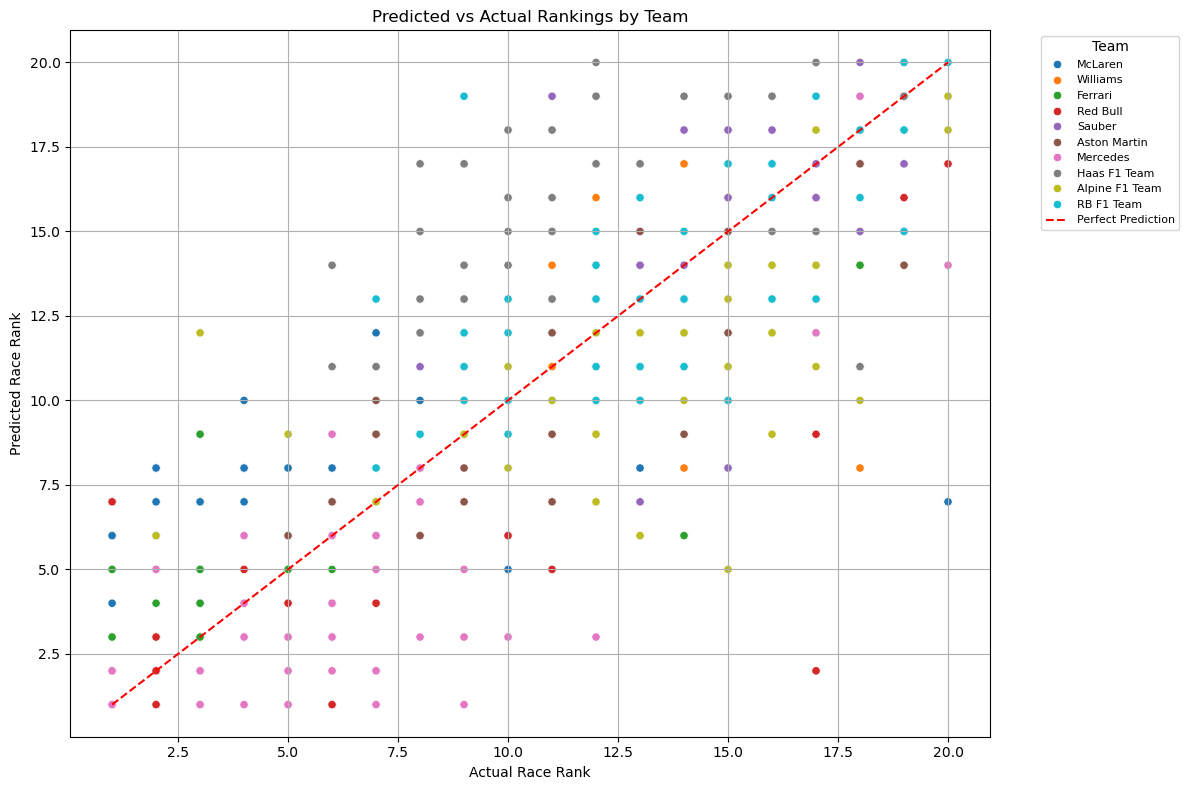

In [26]:
test = test.copy()
test['y_pred'] = y_pred
test['y_true'] = y_test.values


test['actual_rank'] = test.groupby('circuitRef')['y_true'].rank(method='min')
test['predicted_rank'] = test.groupby('circuitRef')['y_pred'].rank(method='min')


plt.figure(figsize=(12, 8))
sns.scatterplot(x='actual_rank', y='predicted_rank', hue='team_name', data=test)

#regression line
plt.plot([1, test['actual_rank'].max()], [1, test['actual_rank'].max()], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Race Rank')
plt.ylabel('Predicted Race Rank')
plt.title('Predicted vs Actual Rankings by Team')
plt.legend(title='Team', prop={'size': 8}, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# starting vs final positions in train and test

/var/folders/pp/7kcd7b9x19d4xpsjl__8kv940000gn/T/ipykernel_11611/4127589939.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})


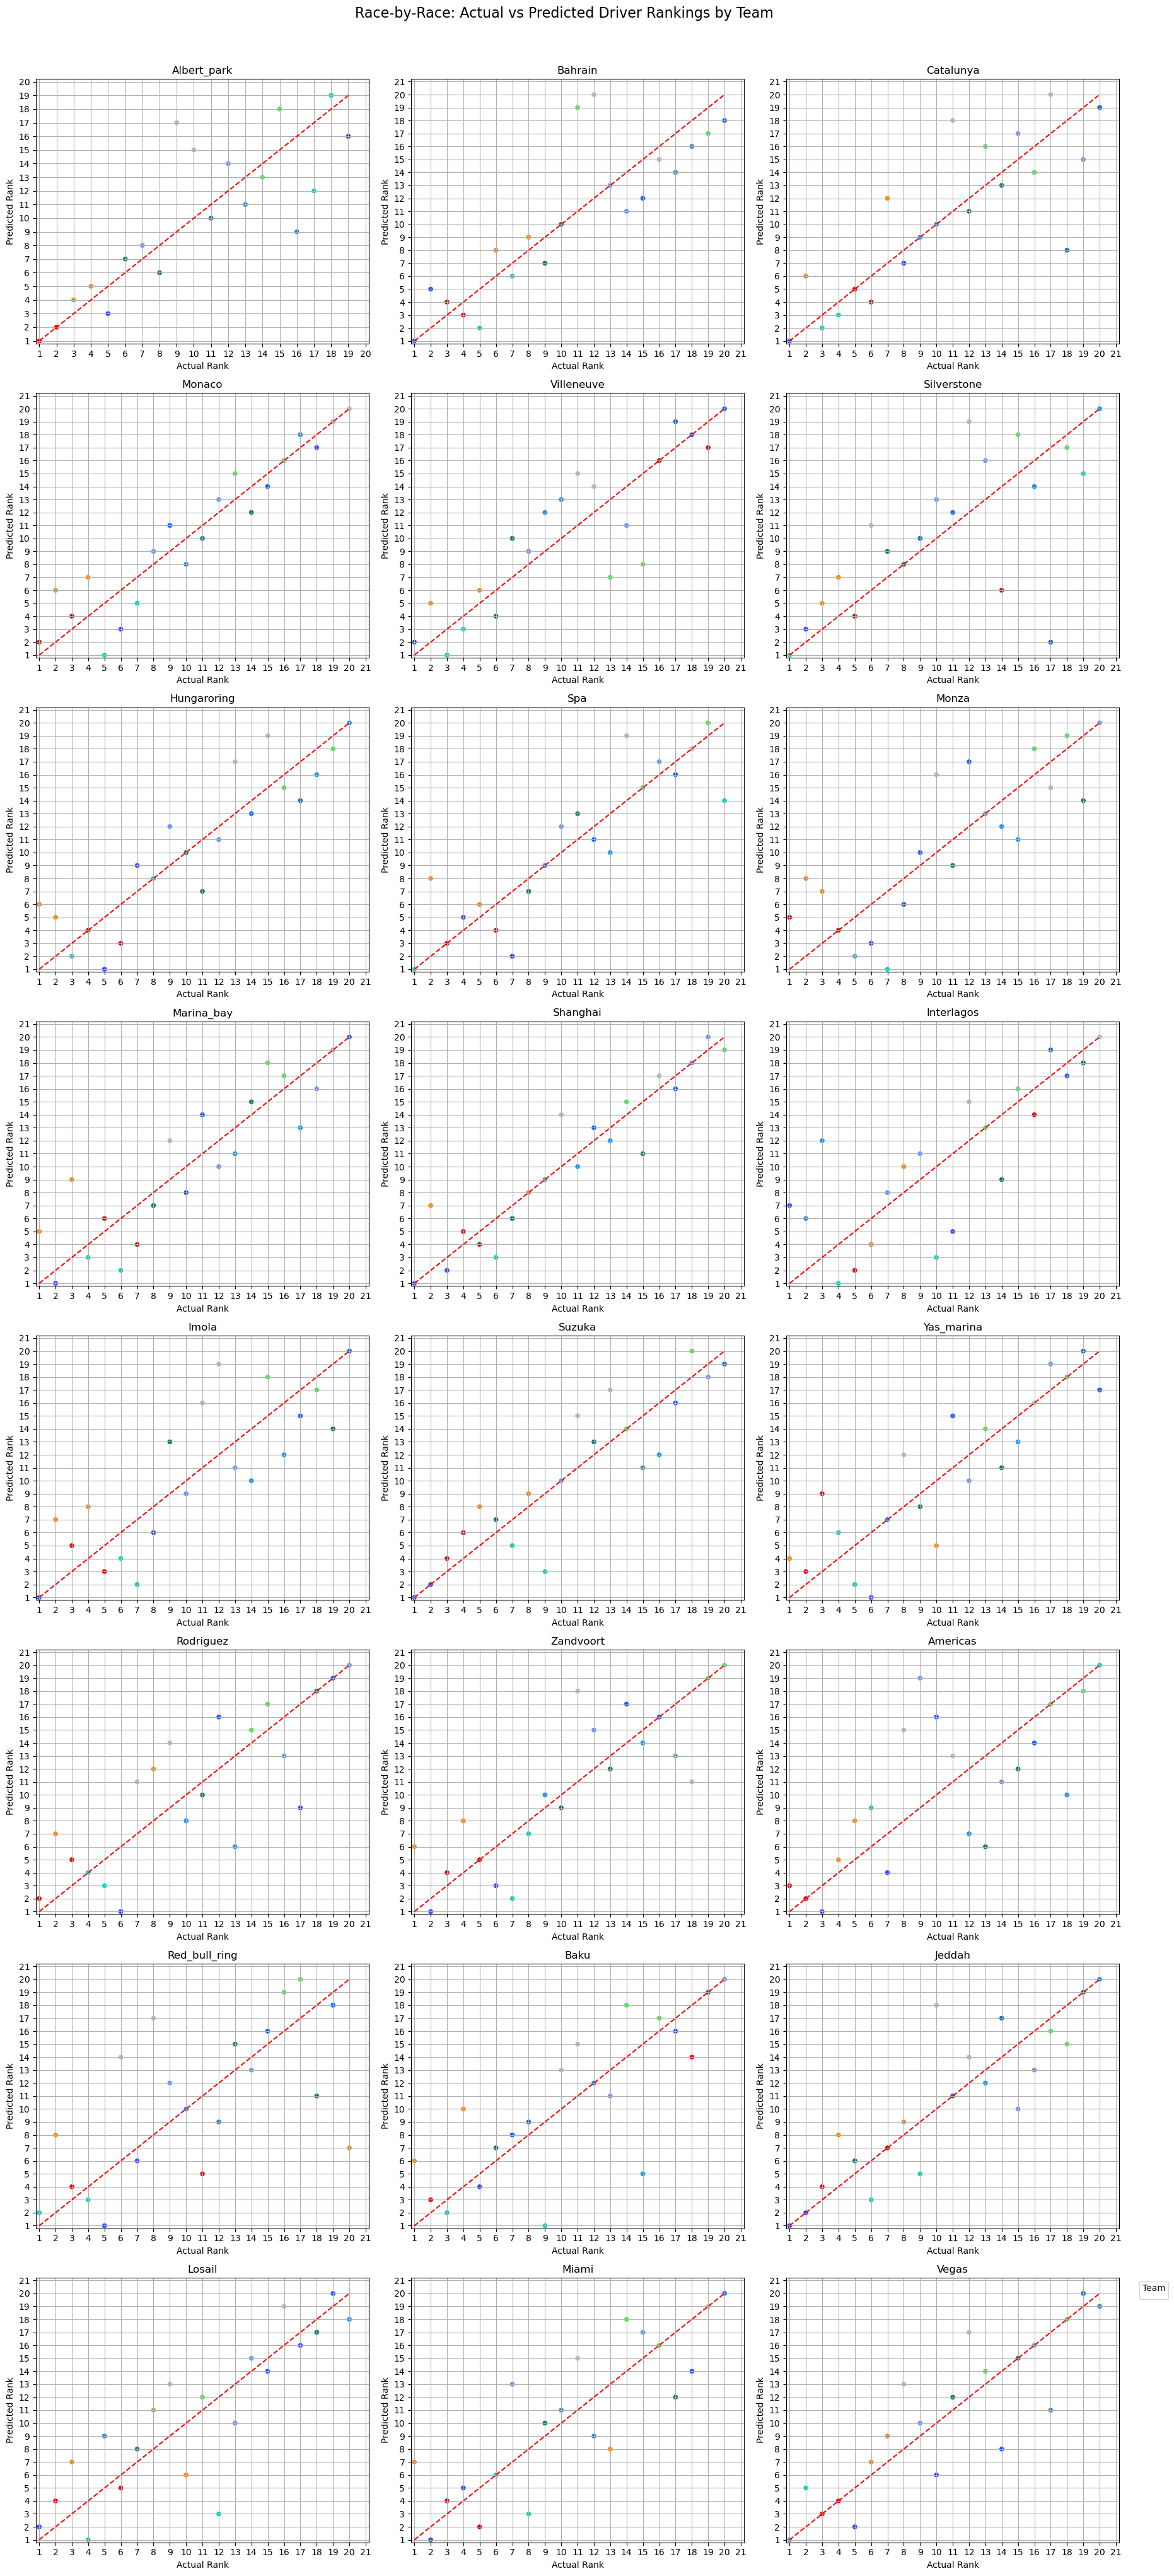

In [28]:
#adding team colors
team_colors = {
    'Red Bull': '#1E41FF',
    'Mercedes': '#00D2BE',
    'Ferrari': '#DC0000',
    'McLaren': '#FF8700',
    'Aston Martin': '#006F62',
    'Alpine F1 Team': '#0090FF',
    'Williams': '#005AFF',
    'RB F1 Team': '#6692FF',
    'Haas F1 Team': '#B6BABD',
    'Sauber': '#52E252',
    #fallback color
    'Other': '#888888'
}
palette = {team: color for team, color in team_colors.items() if team in test['team_name'].unique()}

#getting unique races
races = test['circuitRef'].unique()
n_races = len(races)

cols = 3
rows = math.ceil(n_races / cols)

plt.figure(figsize=(6 * cols, 5 * rows))

for idx, race in enumerate(races):
    ax = plt.subplot(rows, cols, idx + 1)
    
    race_data = test[test['circuitRef'] == race]
    
    sns.scatterplot(
        x='actual_rank', 
        y='predicted_rank', 
        hue='team_name', 
        data=race_data, 
        ax=ax,
        palette=palette,
        legend=False
    )
    
    #regression line
    ax.plot([1, race_data['actual_rank'].max()], [1, race_data['actual_rank'].max()], 'r--')
    
    #scale
    max_rank = int(max(race_data['actual_rank'].max(), race_data['predicted_rank'].max())) + 1
    ax.set_xticks(range(1, max_rank + 1))
    ax.set_yticks(range(1, max_rank + 1))
    
    ax.set_xlim(0.8, max_rank + 0.2)
    ax.set_ylim(0.8, max_rank + 0.2)

    ax.set_title(f'{race.capitalize()}')
    ax.set_xlabel('Actual Rank')
    ax.set_ylabel('Predicted Rank')
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Race-by-Race: Actual vs Predicted Driver Rankings by Team', fontsize=16, y=1.02)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})
plt.show()

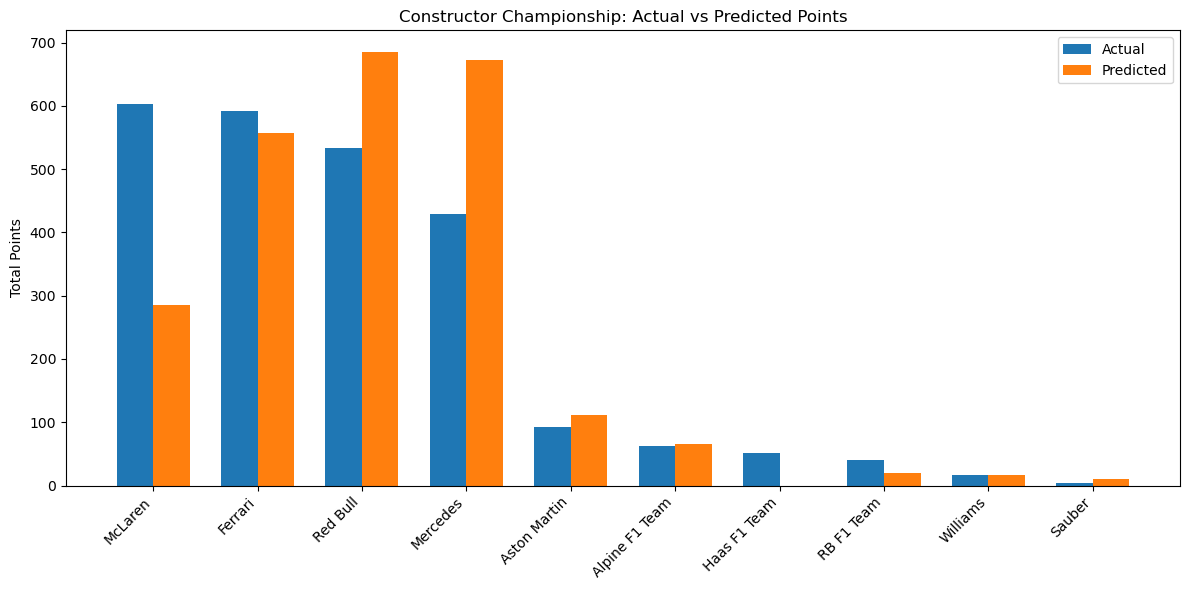

        team_name  actual_points  predicted_points
4         McLaren            603               286
2         Ferrari            591               557
7        Red Bull            533               685
5        Mercedes            429               672
1    Aston Martin             93               112
0  Alpine F1 Team             63                65
3    Haas F1 Team             51                 0
6      RB F1 Team             40                20
9        Williams             17                17
8          Sauber              4                10


In [29]:
def position_to_points(pos):
    points_map = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10,
                  6: 8, 7: 6, 8: 4, 9: 2, 10: 1}
    return points_map.get(pos, 0)

test['actual_points'] = test['actual_rank'].apply(position_to_points)
test['predicted_points'] = test['predicted_rank'].apply(position_to_points)

team_points = test.groupby(['team_name', 'circuitRef']).agg({
    'actual_points': 'sum',
    'predicted_points': 'sum'
}).reset_index()


season_totals = team_points.groupby('team_name').agg({
    'actual_points': 'sum',
    'predicted_points': 'sum'
}).reset_index()

#sorting by actual
season_totals = season_totals.sort_values(by='actual_points', ascending=False)


teams = season_totals['team_name']
x = np.arange(len(teams))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, season_totals['actual_points'], width, label='Actual')
ax.bar(x + width/2, season_totals['predicted_points'], width, label='Predicted')

ax.set_ylabel('Total Points')
ax.set_title('Constructor Championship: Actual vs Predicted Points')
ax.set_xticks(x)
ax.set_xticklabels(teams, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

print(season_totals)